In [1]:
!date

Fri Oct 23 15:03:09 PDT 2020


# Batch effects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata

def nd(arr):
    return np.asarray(arr).reshape(-1)

kwd = {
        "xticklabels": [],
    "yticklabels": [],
    "xticks": [],
    "yticks": []
}
    
    
def yex(ax):
    kwd = {
        "xticklabels": [],
    "yticklabels": [],
    "xticks": [],
    "yticks": []
    }
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set(**kwd)
    
    return ax
import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=15

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [5]:
adata = anndata.read_h5ad("../../data/notebook/revision/10xv3_gene.h5ad")

md = pd.read_csv("../../reference/10xv3_cluster_labels/sample_metadata.csv", index_col = 0)
md["sex"] = md["Gender"].apply(lambda x: {"Male": "M", "Female":"F"}.get(x, "X"))

adata.obs["sex"]  = adata.obs.index.map(md["sex"]).values
adata.obs["date"] = adata.obs.index.map(md["Amp_Date"]).values

In [7]:
adata

AnnData object with n_obs × n_vars = 94162 × 31053
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'sex', 'date'
    var: 'gene_name', 'gene_id', 'gene_short_name'

In [8]:
gene = adata[adata.obs.eval("date == '4/26/2019' and subclass_label != 'Low Quality'").values]

In [9]:
batch_id = np.unique(gene.obs.batch.astype(str).values)

In [10]:
batch_id

array(['10L8TX_190430_01_B08', '11L8TX_190430_01_F08',
       '12L8TX_190430_01_G08', '9L8TX_190430_01_A08'], dtype=object)

In [15]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

In [16]:
gene.layers["X"] = gene.X
gene.layers["norm"] = normalize(gene.X, norm='l1', axis=1)*1000000

In [18]:
data = np.zeros((len(batch_id), len(batch_id), 2, gene.shape[1]))

for i in range(len(batch_id)):
    print(i, len(batch_id))
    for j in range(i):
        a = nd(gene[gene.obs.query(f"batch == '{batch_id[i]}'").index].layers["norm"].sum(axis=0))
        b = nd(gene[gene.obs.query(f"batch == '{batch_id[j]}'").index].layers["norm"].sum(axis=0))
        data[i, j, 0] = a
        data[i, j, 1] = b

0 4
1 4
2 4
3 4


In [19]:
vr = np.zeros((len(batch_id), len(batch_id)))
vp = np.zeros((len(batch_id), len(batch_id)))

for i in range(len(batch_id)):
    for j in range(i):
        r, p = stats.pearsonr(data[i, j, 0], data[i, j, 1])
        vr[i, j] =r
        vp[i, j] =p

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.


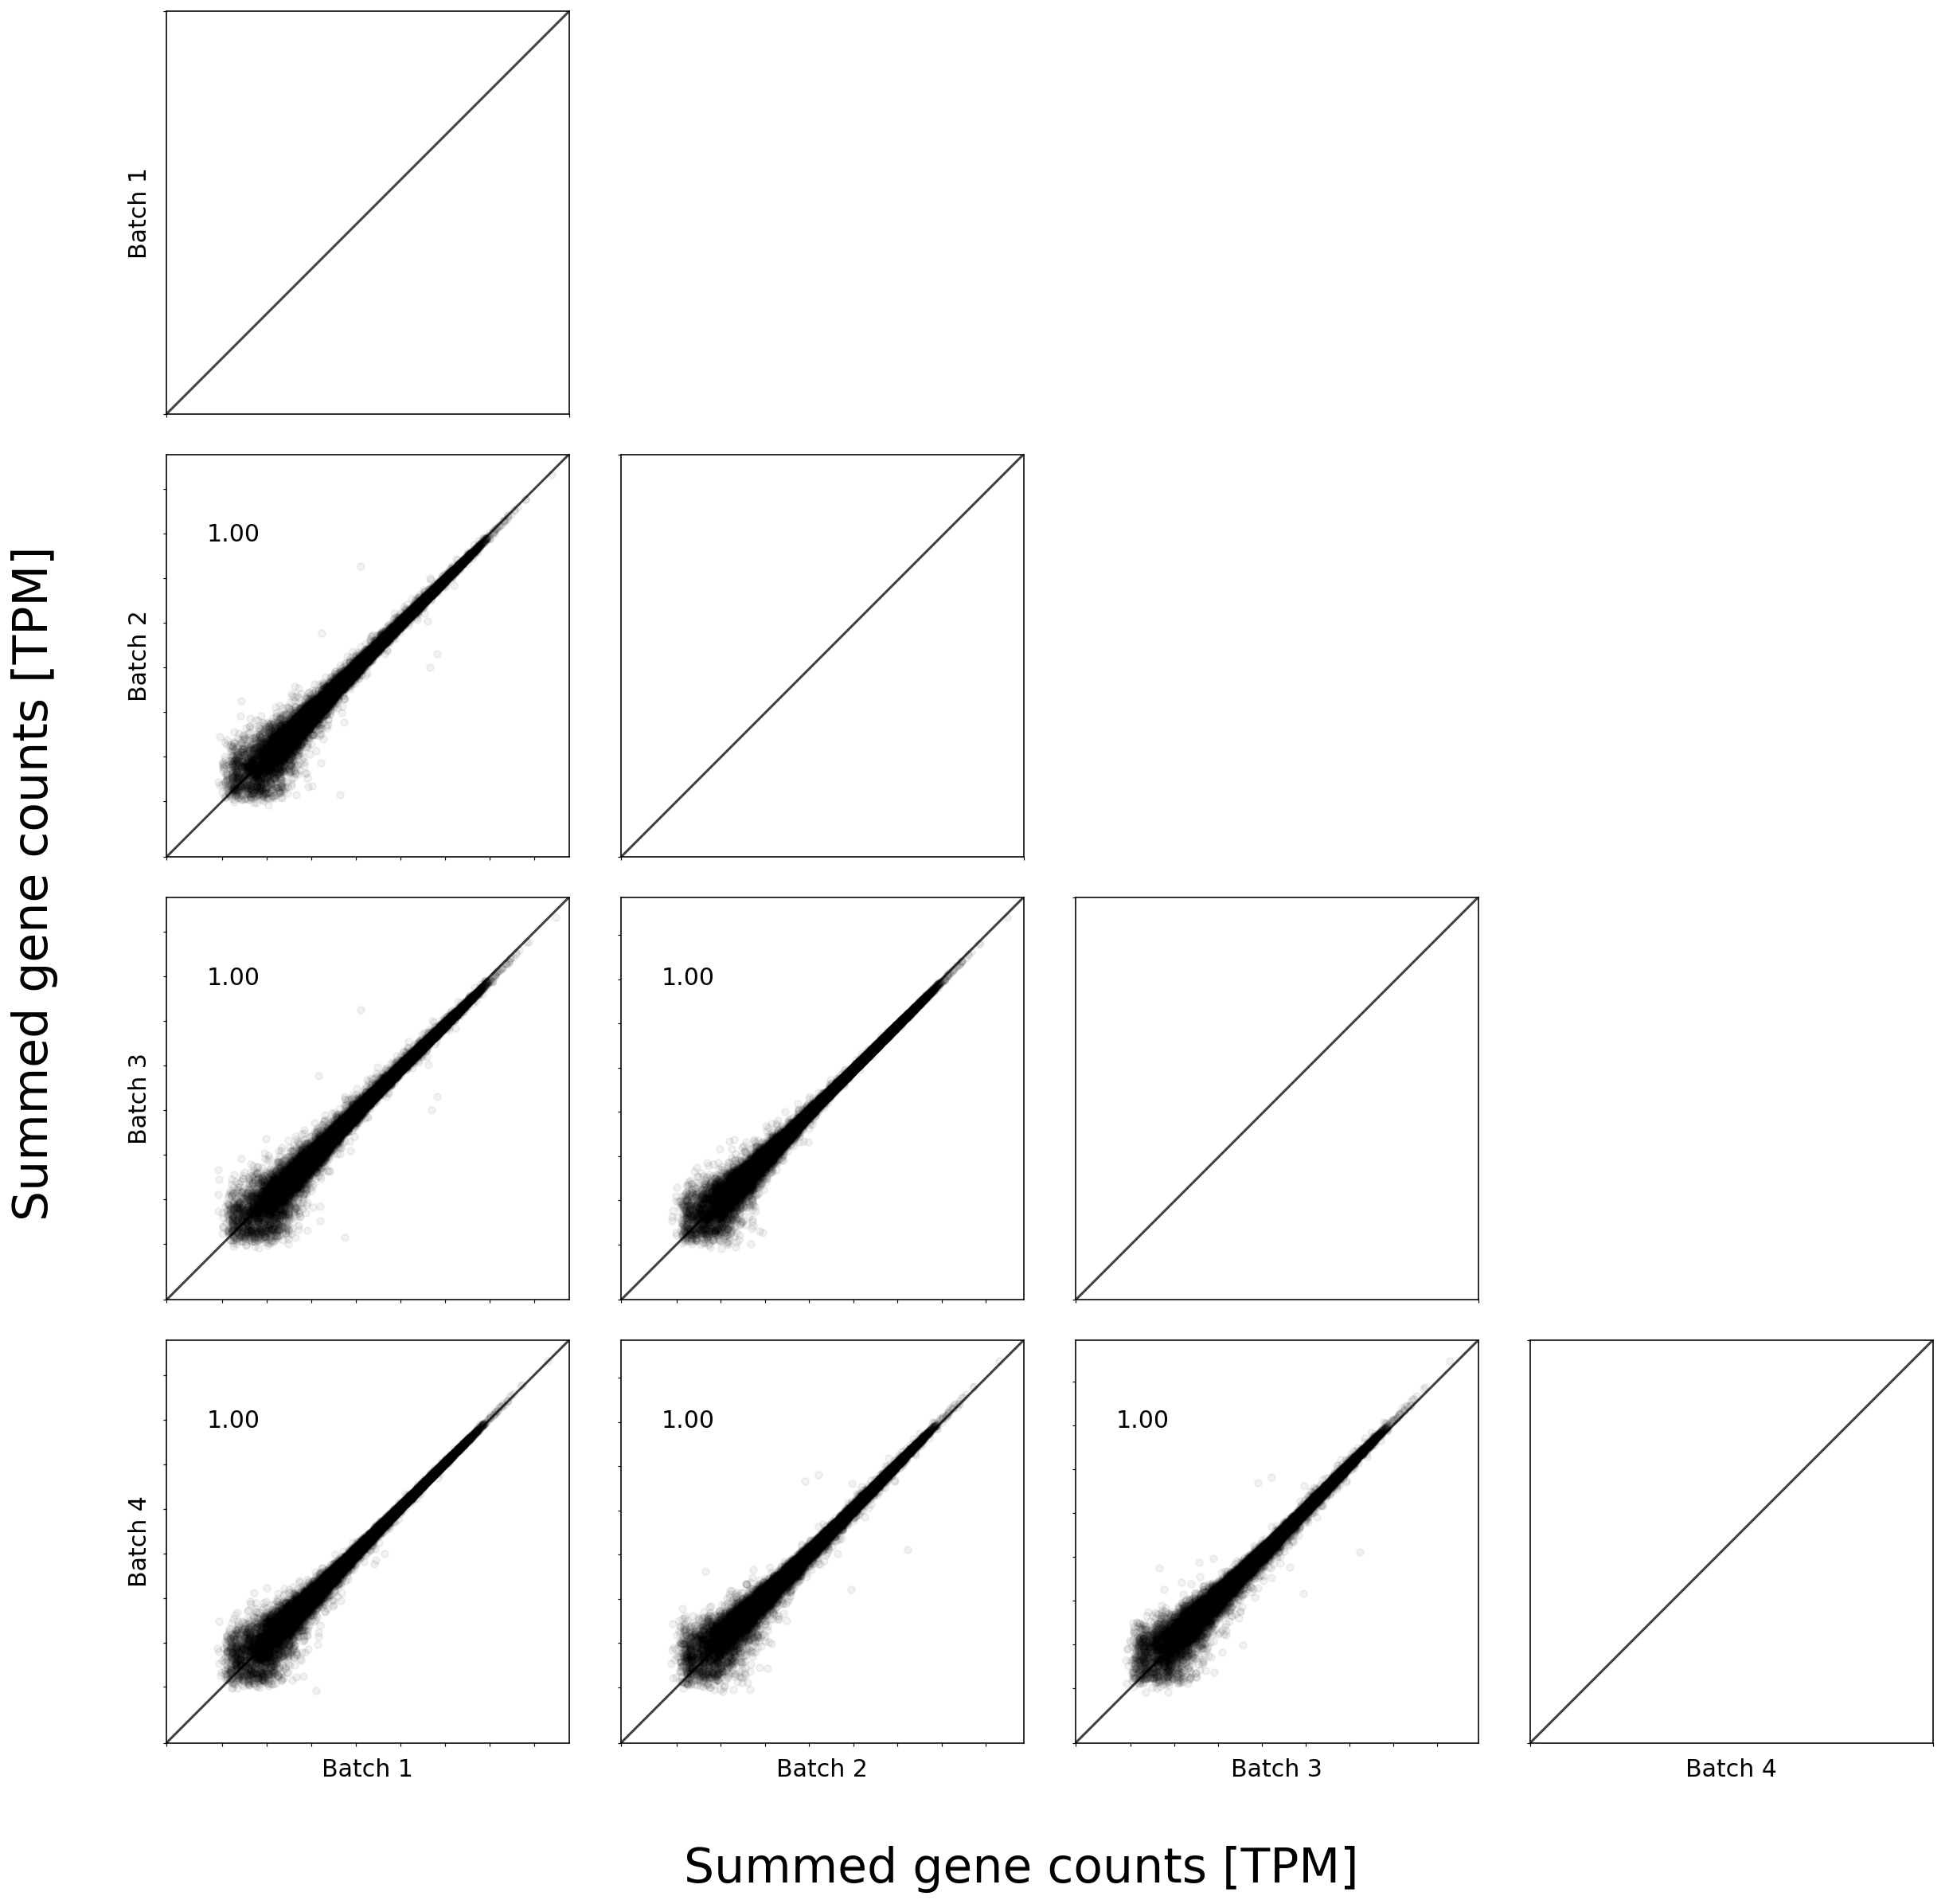

In [41]:
fig, axs = plt.subplots(figsize=(20,20), ncols=len(batch_id), nrows=len(batch_id))
fig.subplots_adjust(hspace=.1, wspace=0.1)


kwd = {
    "xscale": "symlog",
    "yscale": "symlog",
    "xticklabels": [],
    "yticklabels": [],
    "xticks": [],
    "yticks": [],
    "xlim": 1,
    "ylim": 1
    
}

for i in range(len(batch_id)):
    for j in range(len(batch_id)):
        ax = axs[i, j]
        if i<j:
            ax.set_axis_off()
        elif i==j:
            ax.set(**kwd)
            yex(ax)
            ax.set_xticks([])
            ax.set_yticks([])
            if i==3:
                ax.set_xlabel("Batch 4")
            if i==0:
                ax.set_ylabel("Batch 1")


for i in range(len(batch_id)):
    for j in range(i):
        ax = axs[i, j]
        ax.scatter(data[i,j][0], data[i,j][1], alpha=0.05, s=20, color="k")
        ax.set(**kwd)
        yex(ax)
        ax.text(0.1, 0.8,f"{vr[i, j]:,.2f}", ha='left', va='center',transform=ax.transAxes)
        if j == 0:
            ax.set_ylabel(f"Batch {i+1}")
        if i==len(batch_id)-1:
            ax.set_xlabel(f"Batch {j+1}")

fig.text(0.5, 0.07, 'Summed gene counts [TPM]', ha='center', va='center', fontsize=30)
fig.text(0.07, 0.5, 'Summed gene counts [TPM]', ha='center', va='center', rotation='vertical', fontsize=30)        
plt.savefig(trackfig("../../figures/10x_batch_effect.png", TRACKFIG, NB), bbox_inches='tight',dpi=300)
fig.show()

In [46]:
vr.flatten()[vr.flatten()>0].mean()

0.997941871753318

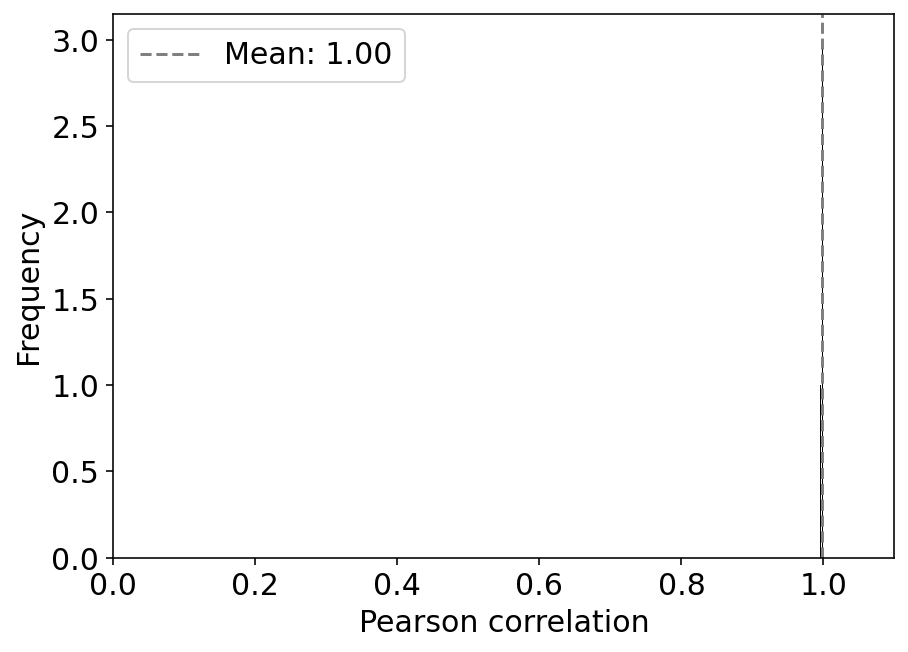

In [43]:
fig, ax = plt.subplots(figsize=(7,5))

x = vr.flatten()[vr.flatten()>0]

ax.hist(x, bins=5, color="k")
ax.axvline(x.mean(), color="grey", linestyle="--", label=f"Mean: {x.mean():.2f}")
kwd = {
    "xlabel": "Pearson correlation",
    "ylabel": "Frequency",
    "xlim": (0, 1.1)
}

ax.set(**kwd)

ax.legend()

plt.show()

In [44]:
def violin_plot(ax, data, labels, lidx, highlight=None):
    if len(data)!=len(labels):
        return
    
    # plot the violin
    parts = ax.violinplot(data, showmedians=False,  showextrema=False)
    # style the violin
    for pcidx, pc in enumerate(parts["bodies"]):
        pc.set_facecolor("#D43F3A")
        if highlight: 
            if pcidx == highlight:
                pc.set_facecolor('#1f77b4')
        
        pc.set_edgecolor("black")
        pc.set_alpha(1)
        
        # plot the actual data
        x = np.random.normal(1, 0.04, size=len(data[pcidx]))
        ax.scatter(x, data[pcidx], alpha=1, color="k")
        

    return ax

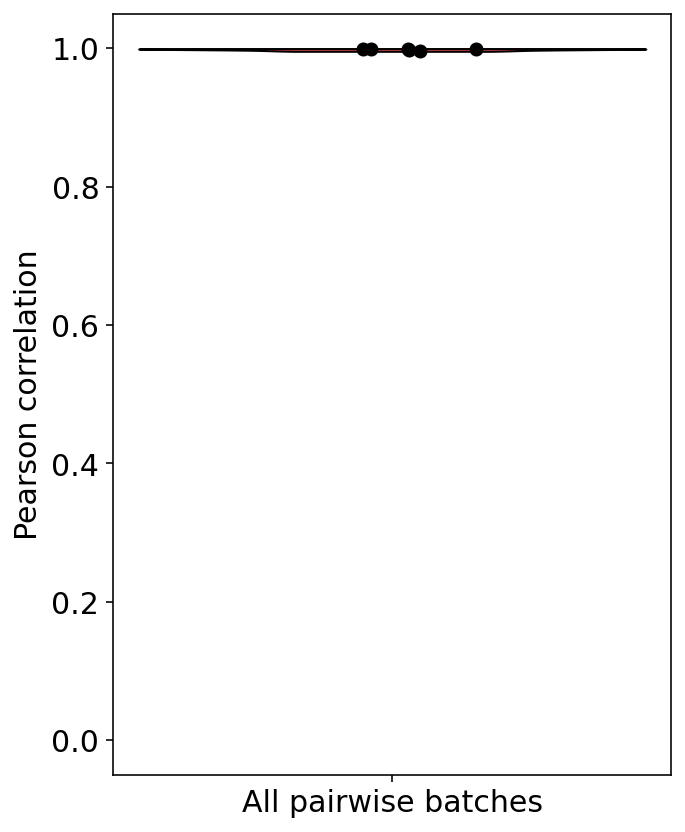

In [45]:
fig, ax = plt.subplots(figsize=(5,7))

x = [vr.flatten()[vr.flatten()>0]]
labels = ["All pairwise batches"]
lidx = np.arange(len(labels)) + 1

violin_plot(ax, x, labels, lidx)

kwd = {
    "xticks": lidx,
    "xticklabels": labels,
    "ylabel": "Pearson correlation",
    "ylim": (-0.05,1.05)
}

ax.set(**kwd)

fig.show()